In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("../")

from vae_interp.vae import VAE
from vae_interp.sae import SAE
from vae_interp.controls import FeaturesControls
from vae_interp.dataset import load_nouns_dataset, NpyDataset
import matplotlib.pyplot as plt

/home/ubuntu/.cache/pypoetry/virtualenvs/swiggle-H3gdtMpT-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
vae = VAE.load_from_dir("../weights/vae")
sae = SAE.load_from_checkpoint("../weights/sae/config.json",
                               "../weights/sae/sae.pth")

In [8]:
nouns_dataset = load_nouns_dataset(image_size=64, normalize=True)

In [9]:
features_controls = FeaturesControls(
    sae=sae, vae=vae, latent_shape=(4, 4, 4)
)

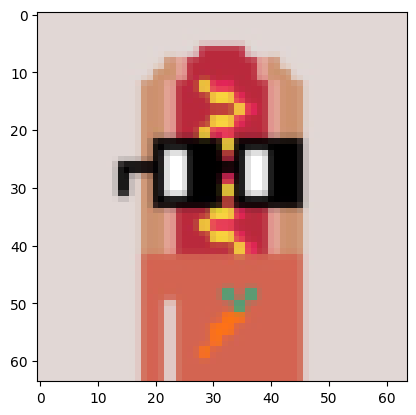

In [10]:
idx = 0
image = nouns_dataset[idx]

plt.imshow((image.permute(1, 2, 0) + 1) * 0.5)

In [11]:
features = features_controls.get_features(image)
features

{112: 0.03437304496765137,
 197: 2.955507278442383,
 481: 0.08602398633956909,
 685: 0.12281584739685059,
 687: 0.03907740116119385,
 896: 0.08587047457695007,
 1000: 0.0675773024559021}

In [16]:
new_features = {**features}
# new_features[202] = 2
# new_features[1] = 3
# new_features[114] = 2
# new_features[497] = 2
# new_features[1] = 2.5
# new_features[197] = 0
new_features

{112: 0.03437304496765137,
 197: 2.955507278442383,
 481: 0.08602398633956909,
 685: 0.12281584739685059,
 687: 0.03907740116119385,
 896: 0.08587047457695007,
 1000: 0.0675773024559021}

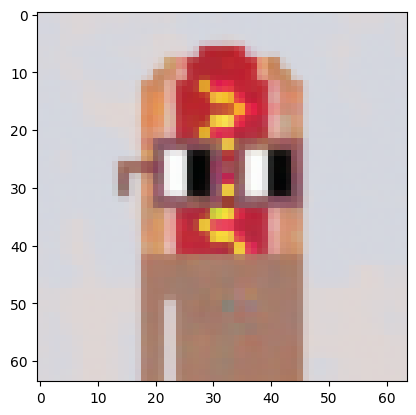

In [17]:
modified_image = features_controls.modify_features(image, new_features)
modified_image = (modified_image - modified_image.min()) / (modified_image.max() - modified_image.min())
modified_image = modified_image.permute(1, 2, 0)

plt.imshow(modified_image)